In [133]:
from builtins import breakpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import sys

sys.path.append("../Laplace")
from laplace.laplace import Laplace
from torch.nn.utils import parameters_to_vector, vector_to_parameters

sys.path.append("../src/")
from utils import save_laplace, load_laplace
from hessian import layerwise as lw

sys.path.append("../stochman")
from stochman import nnj
from torch.nn import functional as F



"""
def create_dataset():

    N = 10000
    X = np.concatenate([np.linspace(0, 0.5, N//2), np.linspace(0.8, 1.2, N//2)]) # random.rand(N)
    y = (
        4.5 * np.cos(2 * np.pi * X + 1.5 * np.pi)
        - 3 * np.sin(4.3 * np.pi * X + 0.3 * np.pi)
        + 3.0 * X
        - 7.5
    ) + 0.3 * np.random.rand(N)
    
    X = torch.tensor(X).unsqueeze(1).type(torch.float)
    y = torch.tensor(y).unsqueeze(1).type(torch.float)
    
    dataloader = DataLoader(TensorDataset(X, y), batch_size=32, pin_memory=True)

    return dataloader
"""

def create_dataset(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = DataLoader(
        TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    #X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return train_loader


def create_model():

    model = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Tanh(),
        #torch.nn.Linear(50, 50),
        #torch.nn.Tanh(),
        #torch.nn.Linear(50, 50),
        #torch.nn.Tanh(),
        #torch.nn.Linear(50, 50),
        #torch.nn.Tanh(),
        torch.nn.Linear(50, 1),
    )

    return model


def train_model(dataset, model):

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(10000):
        total, correct = 0, 0
        for X, y in dataset:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            yhat = model(X)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().detach().numpy())
        #print(epoch, loss)

    #plt.plot(np.array(losses), '-')
    #plt.show()
        
    return model

def compute_hessian_laplace_redux(model, dataloader):

    la = Laplace(
        model,
        "regression",
        hessian_structure="diag",
        subset_of_weights="all",
    )

    la.fit(dataloader)

    # la.optimize_prior_precision()

    return la


0


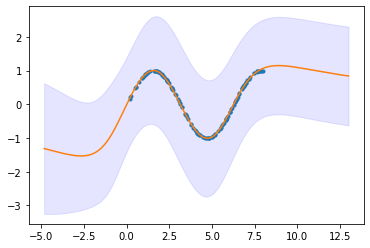

0.3


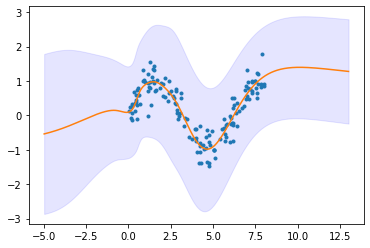

0.6


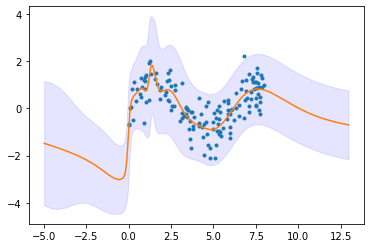

0.9


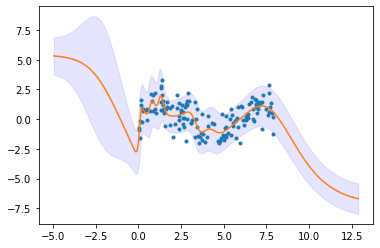

1.2


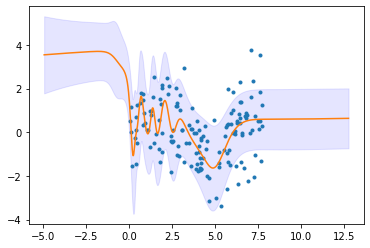

In [134]:
for noise_lvl in [0, 0.3, 0.6, 0.9, 1.2]:
    print(noise_lvl)
    train = True
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    dataset = create_dataset(sigma_noise = noise_lvl)
    model = create_model().to(device)

    # train or load auto encoder
    model = train_model(dataset, model)
    model.eval()

    la = compute_hessian_laplace_redux(model, dataset)
    
    X = dataset.dataset.tensors[0].squeeze()
    y = dataset.dataset.tensors[1]

    plt.plot(X, y, '.')

    model = model.eval()
    X_new = torch.linspace(X.min()-5, X.max()+5, 1000)
    y_new = model(X_new.to(device).unsqueeze(1)).squeeze().cpu().detach().numpy()

    plt.plot(X_new, y_new, '-')

    mu, var = la(X_new.to(device).unsqueeze(1))
    std = var.sqrt().cpu().squeeze().numpy()
    mu = mu.cpu().squeeze().numpy()
    plt.fill_between(X_new, (mu-1.96*std), (mu+1.96*std), color='b', alpha=.1)
    plt.show()

In [187]:
def create_noisy_model():

    model = torch.nn.Sequential(
        NoiseLinear(1, 50),
        #torch.nn.Tanh(),
        #NoiseLinear(50, 50),
        #torch.nn.Tanh(),
        #NoiseLinear(50, 50),
        #torch.nn.Tanh(),
        #NoiseLinear(50, 50),
        torch.nn.Tanh(),
        NoiseLinear(50, 1),
    )

    return model


class NoiseLinear(torch.nn.Linear):
    def __init__(self, in_channels, out_channels):
        super(NoiseLinear, self).__init__(in_channels, out_channels)
        
        #self.temp = torch.nn.Parameter(torch.ones(1)).to(self.weight.device)
        self.std_weight =  0.01 * torch.randn_like(self.weight).to(self.weight.device)
        self.std_bias = 0.01 * torch.randn_like(self.bias).to(self.bias.device)
                        
    def forward(self, input):
        
        weight = self.weight +  self.std_weight.to(self.weight.device) * torch.randn_like(self.weight, device=self.weight.device)
        bias = self.bias +  self.std_bias.to(self.bias.device) * torch.randn_like(self.bias, device=self.bias.device)
        return F.linear(input, weight, bias)
    
def inference(X, noisy_model):
    with torch.inference_mode():
        
        mu_batch, mu2_batch = 0, 0
        for i in range(100):
            pred = noisy_model(X.to(device).unsqueeze(1))

            mu_batch += pred
            mu2_batch += pred**2

        mu = mu_batch / 100
        var = (mu2_batch / 100) - mu**2

    return mu, var


def train_noisy_model(dataset, model):

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(10000):
        total, correct = 0, 0
        for X, y in dataset:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            yhat = model(X)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().detach().numpy())
        #print(epoch, loss)

    plt.plot(np.array(losses), '-')
    plt.show()
        
    return model

0


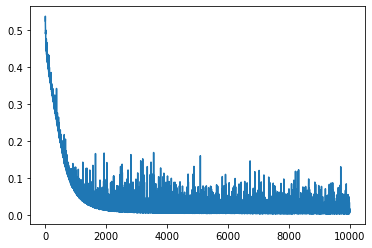

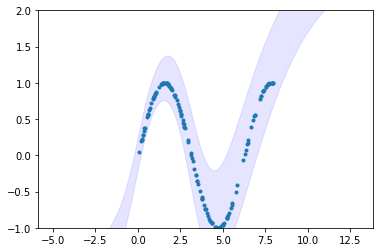

0.3


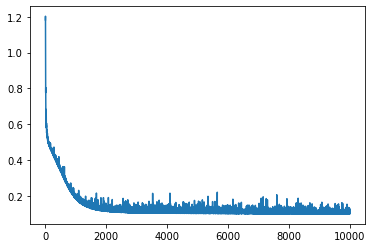

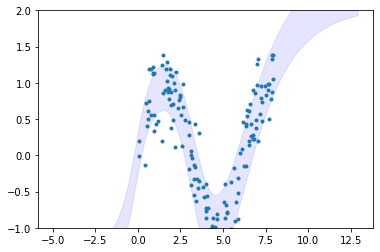

0.6


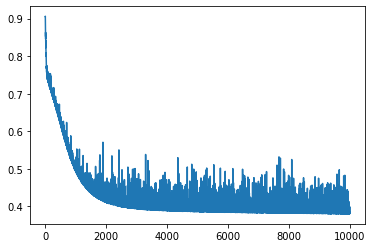

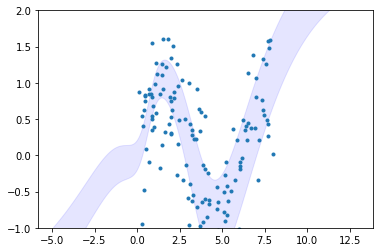

0.9


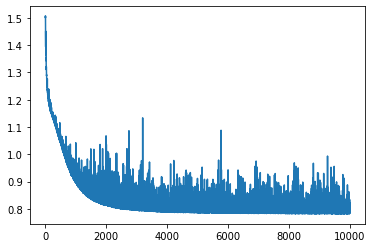

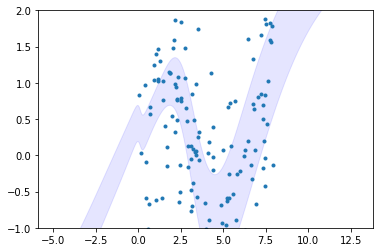

1.2


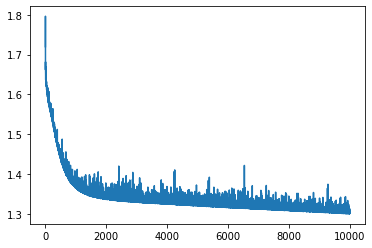

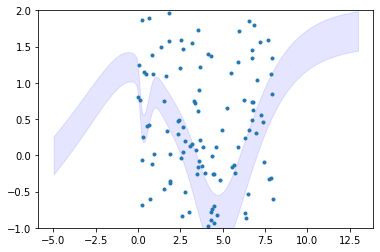

In [188]:
for noise_lvl in [0, 0.3, 0.6, 0.9, 1.2]:
    print(noise_lvl)
    
    train = True
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    dataset = create_dataset(sigma_noise = noise_lvl)
    noisy_model = create_noisy_model().to(device)
    
    X = dataset.dataset.tensors[0].squeeze()
    y = dataset.dataset.tensors[1]

    # train or load auto encoder
    noisy_model = train_noisy_model(dataset, noisy_model)

    noisy_model.eval()
    #print(noisy_model[0].temp, noisy_model[2].temp)
    X_new = torch.linspace(X.min()-5, X.max()+5, 1000)

    mu_noisy, var_noisy = inference(X_new, noisy_model)
    std_noisy = var_noisy.sqrt().cpu().squeeze().numpy()
    mu_noisy = mu_noisy.cpu().squeeze().numpy()
    plt.fill_between(X_new, (mu_noisy-5*std_noisy), (mu_noisy+5*std_noisy), color='b', alpha=.1)

    plt.plot(X, y, '.')
    plt.ylim([-1, 2])
    plt.show()


(Parameter containing:
 tensor([0.1187], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0016], device='cuda:0', requires_grad=True))